In [27]:
from itertools import combinations
from collections import deque
from typing import Deque, Dict, Tuple, List, Set
import matplotlib.pyplot as plt
%matplotlib ipympl


Объявления типов и вспомогательной функции

In [28]:
MutualResistivities = Dict[Tuple[int, int], complex]


class NetworkResistanceRangeAC:
    """ 
        Такой класс в проекте уже объявлен и используется, конвертация
        из List<AcNetwork> в List<NetworkResistanceRangeAC> также есть.
    """

    def __init__(self, xMax: float, rr: MutualResistivities) -> None:
        self.xMax = xMax
        self.rr = rr


class ISchemaNode:
    """ Похожий интерфейс используется в проекте """

    def __init__(self, trackNumber: int, axisCoordinate: float, breaking=False) -> None:
        self.breaking = breaking
        self.trackNumber = trackNumber
        self.axisCoordinate = axisCoordinate
        self.duplicatedBreakingNode = False

    def __repr__(self) -> str:
        if self.breaking:
            return f"!{self.axisCoordinate}"
        if self.duplicatedBreakingNode:
            return f"~{self.axisCoordinate}"
        return str(self.axisCoordinate)

    def __eq__(self, __o: object) -> bool:
        if __o is None or type(__o) is not ISchemaNode:
            return False
        else:
            return (
                eq(self.axisCoordinate, __o.axisCoordinate) and
                self.breaking == __o.breaking and
                self.duplicateBreakingNode == __o.duplicateBreakingNode and
                self.trackNumber == __o.trackNumber
            )

    def __hash__(self):
        b = 1 if self.breaking else 0
        d = 1 if self.duplicatedBreakingNode else 0
        return int(100_000_000 * d + 10_000_000 * b + 1_000_000 * self.trackNumber + self.axisCoordinate)

    def copy(self, trackNumber: int = None, axisCoordinate: float = None, breaking=None):
        tn = trackNumber if trackNumber is not None else self.trackNumber
        x = axisCoordinate if axisCoordinate is not None else self.axisCoordinate
        b = breaking if breaking is not None else self.breaking
        return ISchemaNode(tn, x, b)


class ISchemaEdge:
    """ Похожий интерфейс используется в проекте """

    def __init__(self, source: ISchemaNode, target: ISchemaNode, resistance: complex = 0+0j) -> None:
        self.source = source
        self.target = target
        self.resistance = resistance

    def setConductivity(self, conductivity: float):
        self.c = conductivity
    
    def __repr__(self) -> str:
        return f"{self.source} -> {self.target}"


def eq(x1: float, x2: float, tol: float = 0.5e-3):
    """ Функция сравнивает числа с заданной точностью. Есть в проекте. """
    return abs(x1 - x2) <= abs(tol)


In [29]:
class Network:
    """ Представление тяговой сети в удобной для трассировщика форме. """

    def __init__(self, ranges: List[NetworkResistanceRangeAC]) -> None:
        self.__ranges = ranges
        self.__dict = {}

    def getResistances(self, x1: float, x2: float) -> Dict[int, complex]:
        """
            Возвращает хэш-таблицу с собственными и взаимными сопротивлениями для участка КС
            между координатами x1 и x2. Похожая функция уже есть в проекте, но в такой форма,
            кажется, будет удобнее.
        """
        self.__dict.clear()
        xLeft = x1
        xRight = x2
        for r in self.__ranges:
            if r.xMax <= xLeft:
                continue
            elif r.xMax >= xRight:
                dx = xRight - xLeft
                for tn, mr in r.rr.items():
                    if tn not in self.__dict:
                        self.__dict[tn] = 0+0j
                    self.__dict[tn] += (mr * dx)
                return self.__dict
            elif r.xMax > xLeft and r.xMax < xRight:
                dx = r.xMax - xLeft
                xLeft = r.xMax
                for tn, mr in r.rr.items():
                    if tn not in self.__dict:
                        self.__dict[tn] = 0+0j
                    self.__dict[tn] += (mr * dx)
        raise Exception(
            f"Ошибка трассировки схемы: контактная сеть не определена для интервала координат {xLeft}-{xRight}")


ranges = [
    NetworkResistanceRangeAC(
        xMax=10,
        rr={
            1: 1.1+1.1j,
            2: 2.1+2.1j,
            3: 3.1+3.1j
        }
    ),
    NetworkResistanceRangeAC(
        xMax=20,
        rr={
            1: 1.2+1.2j,
            2: 2.2+2.2j,
            3: 3.2+3.2j
        }
    ),
    NetworkResistanceRangeAC(
        xMax=30,
        rr={
            1: 1.3+1.3j,
            2: 2.3+2.3j,
            3: 3.3+3.3j
        }
    )
]

network = Network(ranges)
network.getResistances(5, 25)


{1: (24+24j), 2: (44+44j), 3: (64+64j)}

In [30]:
class SectionNodeIterator:
    """
        Итератора по параллельным сечениям (см. картинку в конце документа).
        При каждом вызове возвращает два списка узло: левого сечения и правого сечения.
        Сечение строится через каждую координату на К и/или П линиях, в которую установлен узел.
        Если на какой-то линии в текущем сечении нет узла, итератор создаст новый.
        См. визуализацию в конце документа.
    """

    def __init__(self, nodes: Dict[int, Deque[ISchemaNode]]) -> None:
        self.__cnNodes = nodes

    def __iter__(self):
        self.__right: Dict[int, ISchemaNode] = {
            tn: None for tn in self.__cnNodes}
        self.__left: Dict[int, ISchemaNode] = {
            tn: None for tn in self.__cnNodes}
        self.__cnt = 0
        return self

    def __next__(self) -> Tuple[Dict[int, ISchemaNode], Dict[int, ISchemaNode]]:
        leftMostNode: ISchemaNode = None
        tmp = self.__left
        self.__left = self.__right
        self.__right = tmp
        self.__substituteBreakingNodes(self.__left)
        for tn, q in self.__cnNodes.items():
            node = q.popleft() if len(q) > 0 else None
            self.__right[tn] = node
            if node is not None:
                if leftMostNode is None or node.axisCoordinate < leftMostNode.axisCoordinate:
                    leftMostNode = node

        if leftMostNode is None:
            raise StopIteration

        for tn, q in self.__cnNodes.items():
            node = self.__right[tn]
            if node is None:
                self.__right[tn] = leftMostNode.copy(trackNumber=tn, breaking=False)
            elif not eq(node.axisCoordinate, leftMostNode.axisCoordinate):
                q.appendleft(self.__right[tn])
                self.__right[tn] = leftMostNode.copy(trackNumber=tn, breaking=False)

        self.__cnt += 1
        if self.__cnt == 1:
            return self.__next__()
        else:
            return self.__left, self.__right

    def __substituteBreakingNodes(self, d: Dict[int, ISchemaNode]) -> None:
        for i, n in d.items():
            if n is not None and n.breaking:
                clone = ISchemaNode(n.trackNumber, n.axisCoordinate)
                clone.duplicatedBreakingNode = True
                d[i] = clone


In [37]:
class Graph:
    """ Имитирует граф схемы """

    def __init__(self, nodes: List[ISchemaNode]) -> None:
        self.__nodes: Set[ISchemaNode] = set()
        self.__edges: Set[ISchemaEdge] = set()
        self.__nodesBeforeWiring: Set[ISchemaNode] = set()
        for n in nodes:
            self.addNode(n)
            self.__nodesBeforeWiring.add(n)

    def addNode(self, node: ISchemaNode) -> None:
        """ Добавить узел """
        self.__nodes.add(node)

    def addEdge(self, edge: ISchemaEdge) -> None:
        """ Добавить ребро """
        self.__edges.add(edge)

    def getIterator(self) -> SectionNodeIterator:
        """ Создает и возвращает итератор по сечениям """
        cnNodes: Dict[int, Deque[ISchemaNode]] = {}
        for node in self.__nodes:
            tn = node.trackNumber
            if tn not in cnNodes:
                cnNodes[tn] = deque()
            cnNodes[tn].append(node)
        return SectionNodeIterator(cnNodes)

    def plot(self) -> None:
        """ Разместить узлы и ребра на графике """
        f, (ax1, ax2) = plt.subplots(2)

        xxSrc = []
        yySrc = []
        ccSrc = []
        for n in self.__nodesBeforeWiring:
            c = "red" if n.breaking else "black"
            ccSrc.append(c)
            xxSrc.append(n.axisCoordinate)
            yySrc.append(n.trackNumber)
        ax1.scatter(xxSrc, yySrc, c=ccSrc, s=5)

        xx = []
        yy = []
        cc = []
        edges = []
        connectedNodes: Set[ISchemaNode] = set()
        for e in self.__edges:
            for n in (e.source, e.target):
                if n not in connectedNodes and n.duplicatedBreakingNode:
                    n.axisCoordinate += 0.25
            connectedNodes.add(e.source)
            connectedNodes.add(e.target)
            edges.append([e.source.axisCoordinate, e.target.axisCoordinate])
            edges.append([e.source.trackNumber, e.target.trackNumber])
        for n in connectedNodes:
                c = "blue"
                if n in self.__nodesBeforeWiring:
                    c = "black"
                if n.breaking:
                    c = "red"
                cc.append(c)
                xx.append(n.axisCoordinate)
                yy.append(n.trackNumber)
        ax2.scatter(xx, yy, c=cc, s=5)
        ax2.plot(*edges, c="black", linewidth=0.2)
        ax1.set_title("До трассировки")
        ax2.set_title("После")
        plt.tight_layout()
        plt.show()

In [32]:
class Router:
    """ Трассировщик """
    
    def __init__(self, graph: Graph, network: Network) -> None:
        self.__graph = graph
        self.__network = network

    def wire(self):
        """ Выполнить трассировку схемы """
        for left, right in self.__graph.getIterator():
            nodes = list(left.values()) + list(right.values())
            for n1, n2 in combinations(nodes, 2):
                self.__graph.addNode(n1)
                self.__graph.addNode(n2)
                self.__graph.addEdge(ISchemaEdge(n1, n2))


Тест

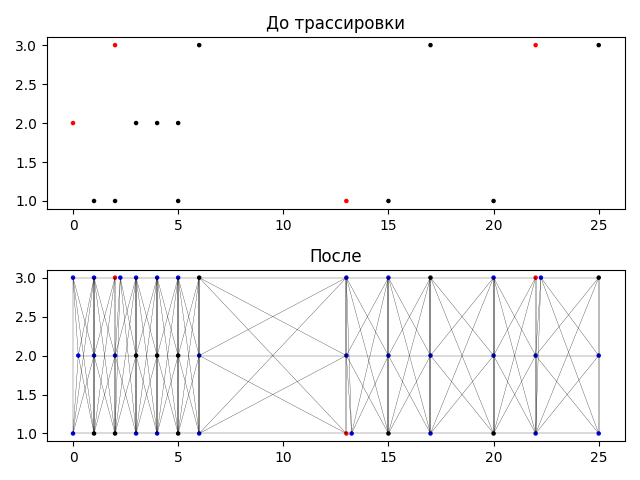

In [38]:
def nodeProducer(tn: int) -> ISchemaNode:
    def _f(x: int, breaking=False):
        return ISchemaNode(tn, x, breaking)
    return _f


np = nodeProducer(1)
n1 = [np(1), np(2), np(5), np(13, True), np(15), np(20)]

np = nodeProducer(2)
n2 = [np(0, True), np(3), np(4), np(5)]

np = nodeProducer(3)
n3 = [np(2, True), np(6), np(17), np(22, True), np(25)]

graph = Graph(n1 + n2 + n3)


r = Router(graph, network)
r.wire()

graph.plot()
